# Introduction of Fed-BioMed through MedNist dataset

**Table of Content**
- 1. Generalities
- 1.1. What is MedNist dataset?
- 1.2. Training a pyTorch model using MedNist dataset
- 2. Getting Started with Fed-BioMed
- 2.1. How does Fed-BioMed Federated Learning framework works?
- 2.2. Accessing information about datasets through List Request
- 2.3. Searching for a specific dataset through the Search Request
- 2.4. Creating a Training Plan
- 2.5. Selecting an Aggregator
- 2.6. Selecting a Node Sampling Strategy
- 2.5 Running your first Federated Learning model!
- 2.6 Gather model results


## What is MONAI ?

project MONAI (https://monai.io/): is a project based on PyTorch framework for Medical Imaging. Fed-BioMed is compatible with MONAI datasets and other features.

Being MONAI based on PyTorch, the deployment within Fed-BioMed follows seamlessly the same general structure of general PyTorch training plans.


## 1.1. What is MedNist dataset?


MedNIST (or Medical MNIST, referring to the MNIST dataset) provides an artificial 2d classification dataset created by gathering different medical imaging datasets from TCIA, the RSNA Bone Age Challenge, and the NIH Chest X-ray dataset. The dataset is kindly made available by Dr. Bradley J. Erickson M.D., Ph.D. (Department of Radiology, Mayo Clinic) under the Creative Commons CC BY-SA 4.0 license.

MedNist dataset contains the following images:
- CT of Abdomen;
- MRI of Breast;
- XRays of Chest;
- CT of Chest;
- XR of Hands;
- CT of Head.


In the cell below we will donwload the MedNIST testing dataset
NB: check if the cell below is needed or already installed on User Notebook

In [1]:
test_data_dir = '/Users/fcremone/docs/fedbiomed-presentations/20231207-isis-castres/MedNIST/MedNIST_clients/client_3/MedNIST/'
client_1_train_data_dir = '/Users/fcremone/docs/fedbiomed-presentations/20231207-isis-castres/MedNIST/MedNIST_clients/client_1/MedNIST/'

In [9]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from monai.transforms import ScaleIntensity, Compose
import numpy as np

# Create a custom pytorch dataset
preprocess = Compose([ToTensor(), ScaleIntensity()
                                        ])
test_data = datasets.ImageFolder(test_data_dir, transform = preprocess)

batch_size = 32
shuffle = True
test_dl = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=shuffle)

In [5]:
labels_name = {0: 'AbdomenCT',
              1: 'BreastMRI',
              2: 'CHestCT', 
              3: 'ChestXR', 
              4: 'Hand', 
              5: 'HeadCT'}

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


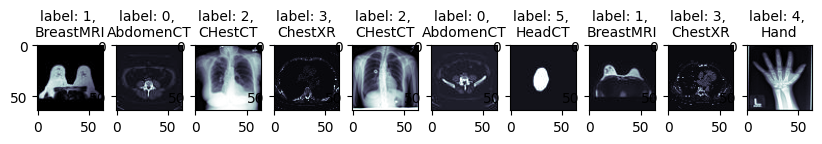

In [6]:
import matplotlib.pyplot as plt
test_dl_iterable = iter(test_dl)

nb_images_to_display = 10  # please make sure nb_images_to_display < batch_size

plt.figure(figsize=(10,2)) 
images, targets = next(test_dl_iterable)
plt.title("Sampled images of MedNIST dataset")
for i in range(nb_images_to_display):
    
    plt.subplot(1,nb_images_to_display, i+1)
    plt.imshow(images[i][0].numpy(), cmap='bone', vmin=0, vmax=1.)
    target_num = targets[i].numpy()
    plt.title(f"label: {target_num}, \n{labels_name[int(target_num)]}", fontsize=10)

Above, a few images of the MedNIST dataset and their corresponding labels

## 1.2. Local Training of MedNist dataset

### 1.2.1 The task
The goal of this dataset is to build a model able to **predict a label given an image**. 

First we will do a local training, using plain PyTorch model, and then create a model using Fed-BioMed.

### 1.2.2 Model definition

We first create a class `LocalMedNISTTrainingPlan` that contains all the components in PyTorch that would be used to train a model locally
we will implement the following methods in the `LocalMedNISTTrainingPlan`:
- `init_model`: handles the initialization of the model
- `init_optimizer`: defines the optimizer
- `training_data`: details how data are handled/ pre-processed before training a model
- `training_step`: defines the loss function

Those methods will be mandatory when defining a model in Fed-BioMed

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LocalMedNISTTrainingPlan:
    def __init__(self, dataset_path: str):
        self.dataset_path = dataset_path

    class MyModel(torch.nn.Module):
        """definition of a PyTorch model, with its __init__ and forward methods"""
        def __init__(self, model_args: dict):
            """PyTorch Model definition"""
            super().__init__()
            self.conv1 = nn.Conv2d(3, 64, 3, 1)
            self.conv2 = nn.Conv2d(64, 128, 3, 1)
            self.fc1 = nn.Linear(115200, 6)
    
        def forward(self, x):
            """Model forward pass"""
            x = self.conv1(x)
            x = F.relu(x)
            x = self.conv2(x)
            x = F.relu(x)
            x = F.max_pool2d(x, 2)
            x = torch.flatten(x, 1)
            x = self.fc1(x)
            x = F.relu(x)    
    
            output = F.log_softmax(x, dim=1)
            return output
        
    def init_model(self, model_args: dict) -> torch.nn.Module:
        """Defines your model here"""
        self.model = self.MyModel(model_args)
        return self.model

    def init_optimizer(self, optimizer_args: dict):
        """Defines your optimizer here"""
        self.optimizer = torch.optim.SGD(self.model.parameters(), optimizer_args['lr'])

    def training_data(self):
        """Defines data handling/parsing here"""
        preprocess = Compose([ToTensor(), 
                              ScaleIntensity(),])
        train_data = datasets.ImageFolder(self.dataset_path, transform = preprocess)
        
        return torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=48, 
                                           shuffle=True)

    def training_step(self, data, target):
        """Defines cost function and how to compute loss"""
        output = self.model.forward(data)

        loss   = torch.nn.functional.nll_loss(output, target)
        return loss
        

Now we define the basic training Loop for training PyTorch models

In [8]:
num_rounds = 7
num_updates_per_round = 100

local_mednist = LocalMedNISTTrainingPlan(dataset_path=client_1_train_data_dir)

local_mednist.init_model({})
local_mednist.init_optimizer({'lr': .001})

losses = list()

for nround in range(1, num_rounds+1):
    nupdate = 0
    avg_loss = 0.
    for data, target in local_mednist.training_data():
        if nupdate >= num_updates_per_round:
            break
        nupdate += 1
        
        local_mednist.model.zero_grad()
        res = local_mednist.training_step(data, target)
        res.backward()
        local_mednist.optimizer.step()
        losses.append(res.item())
        avg_loss += res.item()
        
    avg_loss /= num_updates_per_round
    print(f"Round {nround} average loss for the whole round {avg_loss}")
        

Round 0 loss value 1.3907827138900757
Round 1 loss value 1.2859628200531006
Round 2 loss value 0.8375490307807922
Round 3 loss value 0.9140405058860779
Round 4 loss value 0.7759127020835876


KeyboardInterrupt: 

(599,)

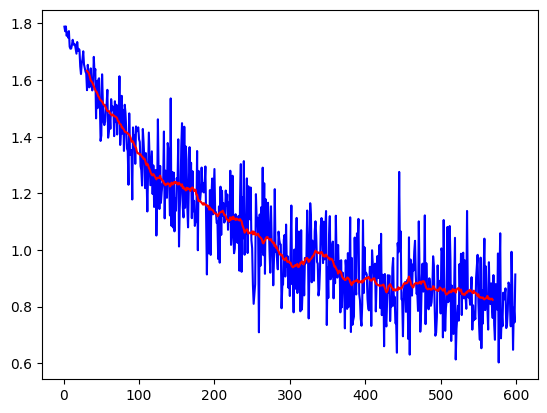

In [33]:
fig, ax = plt.subplots()
ax.plot(np.arange(start=1., stop=len(losses)+1, step=1), 
        losses, '-b')
window_size = 30
moving_avg_loss = np.convolve(losses, np.ones(30), 'same') / 30.
moving_avg_loss[:window_size] = moving_avg_loss[-window_size:] = np.nan
ax.plot(np.arange(start=1., stop=len(losses)+1, step=1),
        moving_avg_loss, '-r')

In [35]:
import tqdm
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# method for testing accuracy given a model and a dataloader
def testing_accuracy(model, data_loader):
    model.eval()
    loss = 0
    correct = 0
    device = 'cpu'

    correct = 0
    y_pred = []
    y_actu = []
    
    with torch.no_grad():
        for data, target in tqdm.tqdm(data_loader, desc=f"Evaluation"):

            data, target = data.to(device), target.to(device)
            output = model(data)

            loss += torch.nn.functional.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            y_pred.extend(torch.flatten(pred).tolist()) 
            y_actu.extend(target.tolist())

        y_pred = pd.Series(y_pred, name='Actual')
        y_actu = pd.Series(y_actu, name='Predicted')
        cm = confusion_matrix(y_actu, y_pred, labels=range(6))

    loss /= len(data_loader.dataset)
    accuracy = 100* correct/len(data_loader.dataset)

    return(loss, accuracy, cm)

In [38]:
test_loss, test_accuracy, test_cm = testing_accuracy(local_mednist.model, test_dl)

Evaluation: 100%|████████████████████████████████████████████████████████████████████████████| 177/177 [01:53<00:00,  1.56it/s]


Test loss = 0.75
Test accuracy = 69.07%


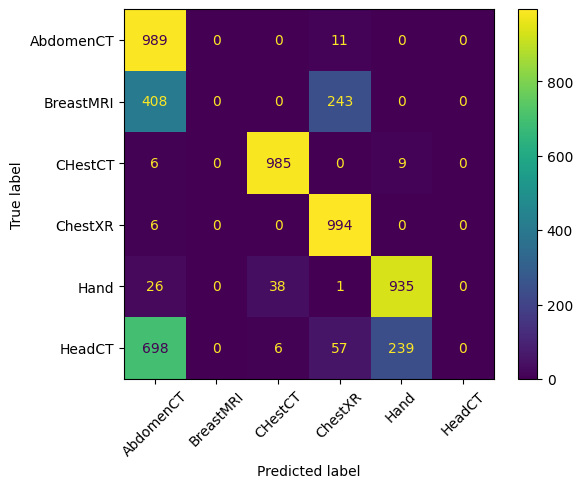

In [39]:
print(f"Test loss = {test_loss:.2f}")
print(f"Test accuracy = {test_accuracy:.2f}%")

disp = ConfusionMatrixDisplay(confusion_matrix=test_cm,
                            display_labels=[labels_name[i] for i in range(6)])

disp.plot(xticks_rotation=45)
plt.show()

**Import attributes**:

Fed-BioMed needs to access those keys attributes: you should not modify them, unless you know what you are doing

- `sell.model`
- `self.optimizer`
- `self.dataset_path`

## 2.1. How does Fed-BioMed Federated Learning framework works?


Although slightly convoluted, `LocalMedNISTTrainingPlan` has a structure which is very close to a TraningPlan object, a piece of code that will be run on each of the Nodes. A TrainingPlan possesses several methods that will be run seperatly on `Nodes`


**MISSING: add images**

## 2.2. Accessing information about datasets through List Request

`Requests` is an object that allows gather information about connected `Nodes`
`List` Requests is a `Request` broadcasted to all connected Nodes for gathering all information about datasets that all connected Nodes are willing to share to the `Researcher`

To issue a `List` Request, one should enter:

In [40]:
from fedbiomed.researcher.requests import Requests
req = Requests()
req.list(verbose=True)

2023-12-04 18:04:08,325 - Selected pickle protocol: '4'


2023-12-04 18:04:08,540 fedbiomed INFO - Messaging researcher_078531f3-2130-404c-8254-f79b1be9cc1a successfully connected to the message broker, object = <fedbiomed.common.messaging.Messaging object at 0x147852f80>
2023-12-04 18:04:08,601 fedbiomed INFO - Listing available datasets in all nodes... 
2023-12-04 18:04:18,627 fedbiomed INFO - 
 Node: node_b1244528-a3a8-423a-b204-cdba821a2f7c | Number of Datasets: 2 
+-----------+----------------+--------------------------+-----------------+-----------------------------------------------------------------------------------------------+----------------------------------------------+----------------------+
| name      | data_type      | tags                     | description     | shape                                                                                         | dataset_id                                   | dataset_parameters   |
+===========+================+==========================+=================+=========================

{'node_b1244528-a3a8-423a-b204-cdba821a2f7c': [{'name': 'decathlon',
   'data_type': 'medical-folder',
   'tags': ['prostate-seg'],
   'description': '',
   'shape': {'image': [320, 320, 24],
    'label': [320, 320, 24],
    'demographics': None,
    'num_modalities': 2},
   'dataset_id': 'dataset_7dfa790d-4b0d-408c-8337-79828eb2b70c',
   'dataset_parameters': {}},
  {'name': 'MEDNIST',
   'data_type': 'mednist',
   'tags': ['#MEDNIST', '#dataset'],
   'description': 'MEDNIST dataset',
   'shape': [18000, 3, 64, 64],
   'dataset_id': 'dataset_5e1e7cf5-819a-46a1-a5f6-6e7db50ab842',
   'dataset_parameters': None}],
 'node_040b8e73-337a-4069-b470-4e76732ebf1d': [{'name': 'promise no bobbina',
   'data_type': 'medical-folder',
   'tags': ['prostate-seg'],
   'description': '',
   'shape': {'image': [384, 384, 28],
    'label': [384, 384, 28],
    'demographics': None,
    'num_modalities': 2},
   'dataset_id': 'dataset_c955ab53-025f-4e53-955c-7ed9b8578da9',
   'dataset_parameters': {}},
  

**Warning: please make sure `List` request returned at least 2 connected `Nodes` **
## 2.3. Creating a TrainingPlan

Training Plan is an Object that should occupy one cell of the Notebook.
Its structure is pretty similar to the object we have been using for the centralized training `LocalMedNISTTrainingPlan`.

Please note that in contrary to `LocalMedNISTTrainingPlan`, `MedNISTTrainingPlan` inherits from `fedbiomed.common.training_plans.TorchTrainingPlan`, an object that specify  Node we are using a PyTorch machine learning framework

In [54]:
import torch
import torch.nn as nn
from fedbiomed.common.training_plans import TorchTrainingPlan
from fedbiomed.common.data import DataManager
from torchvision import datasets, transforms


# Here we define the model to be used. 

class MedNISTTrainingPlan(TorchTrainingPlan):
    class MyModel(torch.nn.Module):
        """definition of a PyTorch model, with its __init__ and forward methods"""
        def __init__(self, model_args: dict):
            """PyTorch Model definition"""
            super().__init__()
            self.conv1 = nn.Conv2d(3, 64, 3, 1)
            self.conv2 = nn.Conv2d(64, 128, 3, 1)
            self.fc1 = nn.Linear(115200, 6)
    
        def forward(self, x):
            """Model forward pass"""
            x = self.conv1(x)
            x = F.relu(x)
            x = self.conv2(x)
            x = F.relu(x)
            x = F.max_pool2d(x, 2)
            x = torch.flatten(x, 1)
            x = self.fc1(x)
            x = F.relu(x)    
    
            output = F.log_softmax(x, dim=1)
            return output
            
    def init_dependencies(self):
        deps = ["from torchvision import datasets",
                "from torchvision.transforms import ToTensor",
                "from monai.transforms import Compose, ScaleIntensity"]

        return deps
    
    def init_model(self, model_args: dict):
        """Defines your model here"""
        return self.MyModel(model_args)

    def init_optimizer(self, optimizer_args):
        """Defines your optimizer here"""
        return torch.optim.SGD(self.model().parameters(), optimizer_args['lr'])

    def training_data(self):
        """Defines data handling/parsing here"""
        # Custom torch Dataloader for MedNIST data

        preprocess = Compose([ToTensor(), ScaleIntensity()])
        train_data = datasets.ImageFolder(self.dataset_path,transform = preprocess)

        return DataManager(dataset=train_data, shuffle=True)
    
    def training_step(self, data, target):
        """Defines cost function and how to compute loss"""
        output = self.model().forward(data)
        loss   = torch.nn.functional.nll_loss(output, target)
        return loss


Among the different shared dataset, we can see the MedNIST dataset. Could you identify how it is made of, and which piece of information will be useful to what is coming next (hint : check **tags**) 

##  2.4. Searching for a specific dataset through the Search Request

A `Search` Request is another Request that will look for dataset that matches a specific tag on all connected Nodes, and will return all Nodes dataset that are marked with this tag.

To issue a `Search` Request, create a `Experiment` object. Then, specify first the tags to be searched across all connected `Nodes`.


In [55]:
model_args = {
}

n_rounds = 7
training_args = {
    'loader_args': { 'batch_size': 48, },
    'optimizer_args': {
        'lr': 1e-3
    }, 
    'num_updates': 100, 
    'log_interval': 10
}

In [56]:
from fedbiomed.researcher.experiment import Experiment

tags =  ['#MEDNIST', '#dataset']

exp = Experiment()



2023-12-04 18:21:19,409 fedbiomed DEBUG - Experiment not fully configured yet: no training data
2023-12-04 18:21:19,411 fedbiomed DEBUG - Experiment not fully configured yet: no node selection strategy
2023-12-04 18:21:19,413 fedbiomed DEBUG - Experiment not fully configured yet: no valid training plan, training_plan_class=None training_plan_class_path=None
2023-12-04 18:21:19,414 fedbiomed DEBUG - Experiment not fully configured yet: no valid training plan, training_plan=None training_plan_path=None
2023-12-04 18:21:19,414 fedbiomed DEBUG - Experiment not fully configured yet: no job. Missing proper training plan definition (training_plan=None training_plan_path=None)


In [57]:
exp.set_model_args(model_args=model_args)
exp.set_training_args(training_args=training_args)

exp.set_round_limit(n_rounds)

7

In [58]:

# set the TrainingPlan into the Experiment
exp.set_tags(tags)
exp.set_training_plan_class(MedNISTTrainingPlan)
training_data = exp.set_training_data(training_data=None, from_tags=True)
exp.set_job()
exp.job()




2023-12-04 18:21:20,018 fedbiomed INFO - Searching dataset with data tags: ['#MEDNIST', '#dataset'] for all nodes
2023-12-04 18:21:30,048 fedbiomed INFO - Node selected for training -> node_b1244528-a3a8-423a-b204-cdba821a2f7c
2023-12-04 18:21:30,050 fedbiomed INFO - Node selected for training -> node_040b8e73-337a-4069-b470-4e76732ebf1d
2023-12-04 18:21:30,051 fedbiomed DEBUG - Training data changed, you may need to update `aggregator`
2023-12-04 18:21:30,055 fedbiomed DEBUG - Model file has been saved: /Users/fcremone/docs/fedbiomed-presentations/20231207-isis-castres/fedbiomed/var/experiments/Experiment_0026/my_model_83a9942d-8d4a-461b-887d-18879875e7bd.py
2023-12-04 18:21:30,083 fedbiomed DEBUG - HTTP POST request of file /Users/fcremone/docs/fedbiomed-presentations/20231207-isis-castres/fedbiomed/var/experiments/Experiment_0026/my_model_83a9942d-8d4a-461b-887d-18879875e7bd.py successful, with status code 201
Secure RNG turned off. This is perfectly fine for experimentation as it a

## 2.5. Selecting an Aggregator: the FedAvg aggregator

`Aggregator` defines the way `Nodes` local models will be aggregated into a gobal model.

`FedAvg Aggregator` consists of aggregating local models using weighted averaging as shown below:

$w_r = \sum_{k=1}^{M} \frac{n_k}{M}w_{r, k}$

In [59]:
from fedbiomed.researcher.aggregators.fedavg import FedAverage
exp.set_aggregator(aggregator=FedAverage)

## 2.6. Selecting a Node Sampling strategy

In Fed-BioMed, a `Strategy` is an object that is responsable of:
- Sampling `Nodes` for each `Round`
- Handle `Nodes` disconnection

In this example, we will select `DefaultStrategy`, a Strategy that doesnot sample any `Nodes` and stops training when at least one `Node` is disconnected or/and fails to reply during training.

In [60]:
from fedbiomed.researcher.strategies.default_strategy import DefaultStrategy
exp.set_strategy(node_selection_strategy=DefaultStrategy)

## 2.7. Monitor the evolution of the loss functions (optional)

It is possible to get the losses in real time from the `Nodes` using [Tensorboard](https://www.tensorflow.org/tensorboard), a tool for plotting loss functions from Tensorflow suit.
To activate `TensorFlow`, 

In [61]:
exp.set_tensorboard(True)


True

In [62]:
from fedbiomed.researcher.environ import environ
tensorboard_dir = environ['TENSORBOARD_RESULTS_DIR']

In [63]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [64]:
tensorboard --logdir "$tensorboard_dir"

Reusing TensorBoard on port 6006 (pid 48176), started 0:16:36 ago. (Use '!kill 48176' to kill it.)

## 2.8. Run Federated Learning model

First, we are going to define parameters required for running the Federated Learning 

- `model_args`: arguments expected for the model, that will be passed in the `init_model` method in the `TrainingPlan`;
- `training_args`: arguments expected for training and running a model,  `training_args` is convoluted, with several layers, including: `optimizer_args`, which contains arguments passed to the `optimizer` defined in the `init_optimizer` of the `TrainingPlan`

One can check the status of the `Experiment`, and how well it is defined, or if some components are missing before running

In [65]:
exp.info()

Arguments             Values
--------------------  ------------------------------------------------------------
Tags                  ['#MEDNIST', '#dataset']
Nodes filter          None
Training Data         <fedbiomed.researcher.datasets.FederatedDataSet object at 0x
                      146cb0f40>
Aggregator            FedAverage
Strategy              <fedbiomed.researcher.strategies.default_strategy.DefaultStr
                      ategy object at 0x148c68430>
Job                   <fedbiomed.researcher.job.Job object at 0x1488ee770>
Aggregator Optimizer  None
Training Plan Path    None
Training Plan Class   <class '__main__.MedNISTTrainingPlan'>
Model Arguments       {}
Training Arguments    {'loader_args': {'batch_size': 48}, 'optimizer_args': {'lr':
                       0.001}, 'num_updates': 100, 'log_interval': 10, 'epochs': N
                      one, 'dry_run': False, 'batch_maxnum': None, 'test_ratio': 0
                      .0, 'test_on_local_updates': False, 'test_on_

In this example we will use a plain FedAvg algorithm, as it has been introdcued by MacMahan et al., 2016

During the training, you may want to track the loss evolution: please refresh the `Tensorboard`  vizualization tool if you have activated it

In [66]:
exp.run()

2023-12-04 18:21:30,420 fedbiomed INFO - Sampled nodes in round 0 ['node_b1244528-a3a8-423a-b204-cdba821a2f7c', 'node_040b8e73-337a-4069-b470-4e76732ebf1d']
2023-12-04 18:21:30,421 fedbiomed INFO - Sending request 
					 To: node_b1244528-a3a8-423a-b204-cdba821a2f7c 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_078531f3-2130-404c-8254-f79b1be9cc1a', 'job_id': 'job_78dbb5a9-e6fd-42c6-a673-fa42d46d19ce', 'training_args': {'loader_args': {'batch_size': 48}, 'optimizer_args': {'lr': 0.001}, 'num_updates': 100, 'log_interval': 10, 'epochs': None, 'dry_run': False, 'batch_maxnum': None, 'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'fedprox_mu': None, 'use_gpu': False, 'dp_args': None, 'share_persistent_buffers': True, 'random_seed': None}, 'training': True, 'model_args': {}, 'round': 0, 'secagg_servkey_id': None, 'secagg_biprime_id': None, 'secagg_random': None, 'secagg_

7

## 3. Gather Federated Learning results

## 3.1. Gather statistics of the training


Local training results for each round and each node are available via `exp.training_replies()` (index 0 to (`rounds` - 1) ).

For example you can view the training results for the last round below.

Different timings (in seconds) are reported for each dataset of a node participating in a round :
- `rtime_training` real time (clock time) spent in the training function on the node
- `ptime_training` process time (user and system CPU) spent in the training function on the node
- `rtime_total` real time (clock time) spent in the researcher between sending the request and handling the response, at the `Job()` layer

In [67]:
print("\nList the training rounds : ", exp.training_replies().keys())

print("\nList the nodes for the last training round and their timings : ")
round_data = exp.training_replies()[n_rounds - 1]
for c in round_data:
    print("\t- {id} :\
    \n\t\trtime_training={rtraining:.2f} seconds\
    \n\t\tptime_training={ptraining:.2f} seconds\
    \n\t\trtime_total={rtotal:.2f} seconds".format(id = c['node_id'],
        rtraining = c['timing']['rtime_training'],
        ptraining = c['timing']['ptime_training'],
        rtotal = c['timing']['rtime_total']))
print('\n')
    
exp.training_replies()[n_rounds - 1][0].keys()


List the training rounds :  dict_keys([0, 1, 2, 3, 4, 5, 6])

List the nodes for the last training round and their timings : 
	- node_040b8e73-337a-4069-b470-4e76732ebf1d :    
		rtime_training=203.03 seconds    
		ptime_training=372.80 seconds    
		rtime_total=215.21 seconds
	- node_b1244528-a3a8-423a-b204-cdba821a2f7c :    
		rtime_training=205.86 seconds    
		ptime_training=376.73 seconds    
		rtime_total=215.25 seconds




dict_keys(['success', 'msg', 'dataset_id', 'node_id', 'state_id', 'params_path', 'params', 'optimizer_args', 'optim_aux_var', 'sample_size', 'encryption_factor', 'timing'])

## 3.2. Gather trained model

Now we are going to retrieve the trained model from the `Experiment`

In [68]:
trained_model = exp.training_plan().model()
trained_model.load_state_dict(exp.aggregated_params()[n_rounds - 1]['params'])

<All keys matched successfully>

## 3.3. Get confusion matrix using the testing dataset

Now we will use the testing dataset to get the confusion matrix


In [69]:
test_loss, test_accuracy, test_cm = testing_accuracy(trained_model, test_dl)

Evaluation: 100%|████████████████████████████████████████████████████████████████████████████| 177/177 [01:59<00:00,  1.48it/s]


Test loss = 0.18
Test accuracy = 96.44%


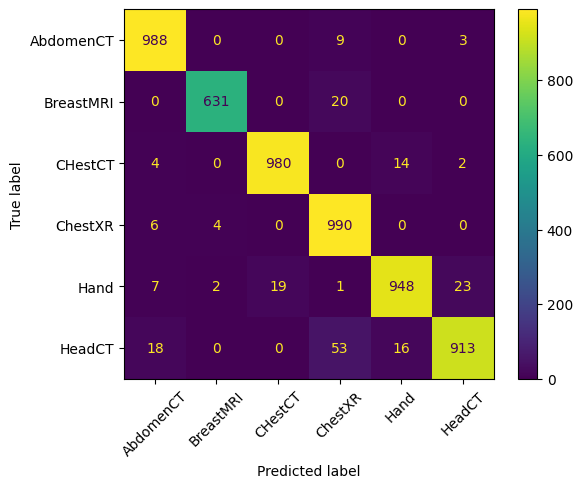

In [70]:
print(f"Test loss = {test_loss:.2f}")
print(f"Test accuracy = {test_accuracy:.2f}%")

disp = ConfusionMatrixDisplay(confusion_matrix=test_cm,
                            display_labels=[labels_name[i] for i in range(6)])

disp.plot(xticks_rotation=45)
plt.show()